### **Aplicacion de clustering para dataset de tarjetas de crédito**

Se utiliza un dataset con datos de clientes de tarjetas de credito. A partir de estos datos se busca comparar la efectividad de K-means y DBSCAN en el dataset seleccionado, evaluando la cohesión e intersección de los clusters obtenidos mediante métricas de evaluación

El dataset se encuentra disponible en Kaggle: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

### **1. Importación de librerias y dataset**

Se importan las librerias a ser utilizadas y el dataset a analizar

In [94]:
# librerias 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
# cluster
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
# reduccion
from sklearn.decomposition import PCA

In [61]:
# importar el dataset 
df = pd.read_csv('creditcard.csv')
df.head(5).T

,0,1,2,3,4
CUST_ID,C10001,C10002,C10003,C10004,C10005
BALANCE,40.900749,3202.467416,2495.148862,1666.670542,817.714335
BALANCE_FREQUENCY,0.818182,0.909091,1.0,0.636364,1.0
PURCHASES,95.4,0.0,773.17,1499.0,16.0
ONEOFF_PURCHASES,0.0,0.0,773.17,1499.0,16.0
INSTALLMENTS_PURCHASES,95.4,0.0,0.0,0.0,0.0
CASH_ADVANCE,0.0,6442.945483,0.0,205.788017,0.0
PURCHASES_FREQUENCY,0.166667,0.0,1.0,0.083333,0.083333
ONEOFF_PURCHASES_FREQUENCY,0.0,0.0,1.0,0.083333,0.083333
PURCHASES_INSTALLMENTS_FREQUENCY,0.083333,0.0,0.0,0.0,0.0


### **2. Limpieza de datos**

En esta sección se verifica la presencia de valores duplicados, outliers, nulos en el dataset con los datos de entrenamiento

### **2.1. Verificacion de tipo de datos**

In [62]:
# info del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Los datos del dataset son del tipo numerico a excepcion de el cust_id

Se extraen todas las columnas del tipo "object" para verificar los valores unicos de cada columna.

In [63]:
# extraer las columnas tipo object
object_columns = df.select_dtypes(include=['object'])

# identificar sus valores unicos 
for column in object_columns:
    unique_values = object_columns[column].unique()
    print(f"Columna '{column}': {unique_values}")

Columna 'CUST_ID': ['C10001' 'C10002' 'C10003' ... 'C19188' 'C19189' 'C19190']


Se procede a realizar el cambio de las columnas object al tipo string

In [64]:
# objeto a category
df = df.astype({col: 'string' for col in df.select_dtypes(include='object').columns})

# resultado
df.dtypes

CUST_ID                             string[python]
BALANCE                                    float64
BALANCE_FREQUENCY                          float64
PURCHASES                                  float64
ONEOFF_PURCHASES                           float64
INSTALLMENTS_PURCHASES                     float64
CASH_ADVANCE                               float64
PURCHASES_FREQUENCY                        float64
ONEOFF_PURCHASES_FREQUENCY                 float64
PURCHASES_INSTALLMENTS_FREQUENCY           float64
CASH_ADVANCE_FREQUENCY                     float64
CASH_ADVANCE_TRX                             int64
PURCHASES_TRX                                int64
CREDIT_LIMIT                               float64
PAYMENTS                                   float64
MINIMUM_PAYMENTS                           float64
PRC_FULL_PAYMENT                           float64
TENURE                                       int64
dtype: object

A modo de verificacion, se analizan los valores unicos de las columnas con formato int64 y float64 para verificar que hayan sido identificadas de manera correcta.

In [65]:
# extraer las columnas tipo int
numerical_columns = df.select_dtypes(include=['int64','float64'])

# identificar sus valores unicos 
for column in numerical_columns:
    unique_values = numerical_columns[column].unique()
    print(f"Columna '{column}': {unique_values}")

Columna 'BALANCE': [  40.900749 3202.467416 2495.148862 ...   23.398673   13.457564
  372.708075]
Columna 'BALANCE_FREQUENCY': [0.818182 0.909091 1.       0.636364 0.545455 0.875    0.454545 0.727273
 0.5      0.888889 0.090909 0.272727 0.363636 0.       0.666667 0.75
 0.857143 0.181818 0.333333 0.6      0.3      0.125    0.9      0.833333
 0.8      0.2      0.777778 0.555556 0.25     0.142857 0.571429 0.4
 0.444444 0.714286 0.222222 0.1      0.625    0.428571 0.111111 0.285714
 0.7      0.375    0.166667]
Columna 'PURCHASES': [  95.4     0.    773.17 ...  291.12  144.4  1093.25]
Columna 'ONEOFF_PURCHASES': [   0.    773.17 1499.   ...  734.4  1012.73 1093.25]
Columna 'INSTALLMENTS_PURCHASES': [  95.4     0.   1333.28 ...  113.28  291.12  144.4 ]
Columna 'CASH_ADVANCE': [   0.       6442.945483  205.788017 ... 8555.409326   36.558778
  127.040008]
Columna 'PURCHASES_FREQUENCY': [0.166667 0.       1.       0.083333 0.666667 0.333333 0.25     0.75
 0.5      0.416667 0.916667 0.583333 0.3

Todos los datos del tipo numerico fueron identificados correctamente. 

### **2.2. Verificacion de valores duplicados**

Se procede a verificar si hay datos duplicados.



In [66]:
# identificar duplicados
duplicados = df.duplicated()

# contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


El dataset no contiene datos duplicados.


### **2.3. Análisis de los valores faltantes**

Se verifica la cantidad y porcentaje de valores faltantes en el dataframe, además de ser necesario se rellenan los datos faltantes.

In [67]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)

# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)

# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)

# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)

# filtrar solo los que tienen NA
na = na[na['Na en q'] > 0]

# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
MINIMUM_PAYMENTS,8637,313,3.50
CREDIT_LIMIT,8949,1,0.01


Los datos faltantes son solo en las columnas de Minimum_payments y credit_limit, a pesar de que los datos faltantes representan menos del 10% de los datos totales, se analiza cada uno.

In [68]:
# filtrar
df[df['MINIMUM_PAYMENTS'].isna()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.0,12
45,C10047,2242.311686,1.000000,437.00,97.00,340.0,184.648692,0.333333,0.083333,0.333333,0.166667,2,5,2400.0,0.000000,NaN,0.0,12
47,C10049,3910.111237,1.000000,0.00,0.00,0.0,1980.873201,0.000000,0.000000,0.000000,0.500000,7,0,4200.0,0.000000,NaN,0.0,12
54,C10056,6.660517,0.636364,310.00,0.00,310.0,0.000000,0.666667,0.000000,0.666667,0.000000,0,8,1000.0,417.016763,NaN,0.0,12
55,C10057,1311.995984,1.000000,1283.90,1283.90,0.0,0.000000,0.250000,0.250000,0.000000,0.000000,0,6,6000.0,0.000000,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,C19160,14.524779,0.333333,152.00,152.00,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,1500.0,0.000000,NaN,0.0,6
8929,C19170,371.527312,0.333333,0.00,0.00,0.0,1465.407927,0.000000,0.000000,0.000000,0.166667,5,0,1500.0,0.000000,NaN,0.0,6
8935,C19176,183.817004,1.000000,465.90,0.00,465.9,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1500.0,0.000000,NaN,0.0,6
8944,C19185,193.571722,0.833333,1012.73,1012.73,0.0,0.000000,0.333333,0.333333,0.000000,0.000000,0,2,4000.0,0.000000,NaN,0.0,6


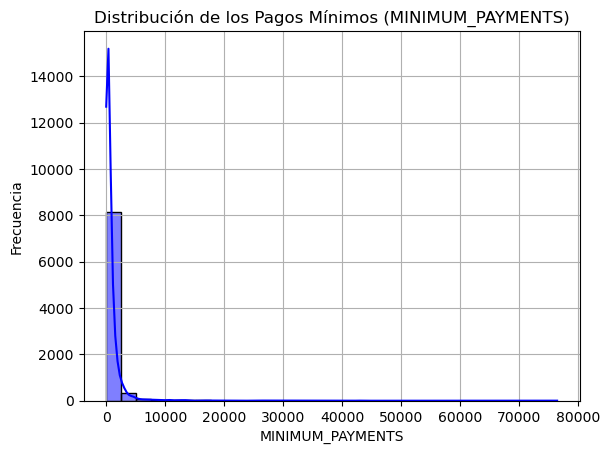

In [69]:
# distribucion de los datos
# filtrar 
df_no_missing = df.dropna(subset=['MINIMUM_PAYMENTS'])

# histograma
sns.histplot(df_no_missing['MINIMUM_PAYMENTS'], kde=True, color='blue', bins=30)

# grafico
plt.title('Distribución de los Pagos Mínimos (MINIMUM_PAYMENTS)')
plt.xlabel('MINIMUM_PAYMENTS')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

Los datos minimos se concentran cercanos a 0

In [70]:
# calcular la mediana 
median_value = df['MINIMUM_PAYMENTS'].median()

# rellenar los valores faltantes
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(median_value)

# verificar 
print(df['MINIMUM_PAYMENTS'].isnull().sum())

0


In [71]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)

# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)

# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)

# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)

# filtrar solo los que tienen NA
na = na[na['Na en q'] > 0]

# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
CREDIT_LIMIT,8949,1,0.01


Eliminar los faltantes de credit limit

In [72]:
# eliminar
df = df.dropna(subset=['CREDIT_LIMIT'])

# verificar 
print(df['MINIMUM_PAYMENTS'].isnull().sum())

0


### **3. Exploracion de datos**

Crear histogramas y boxplots para las variables

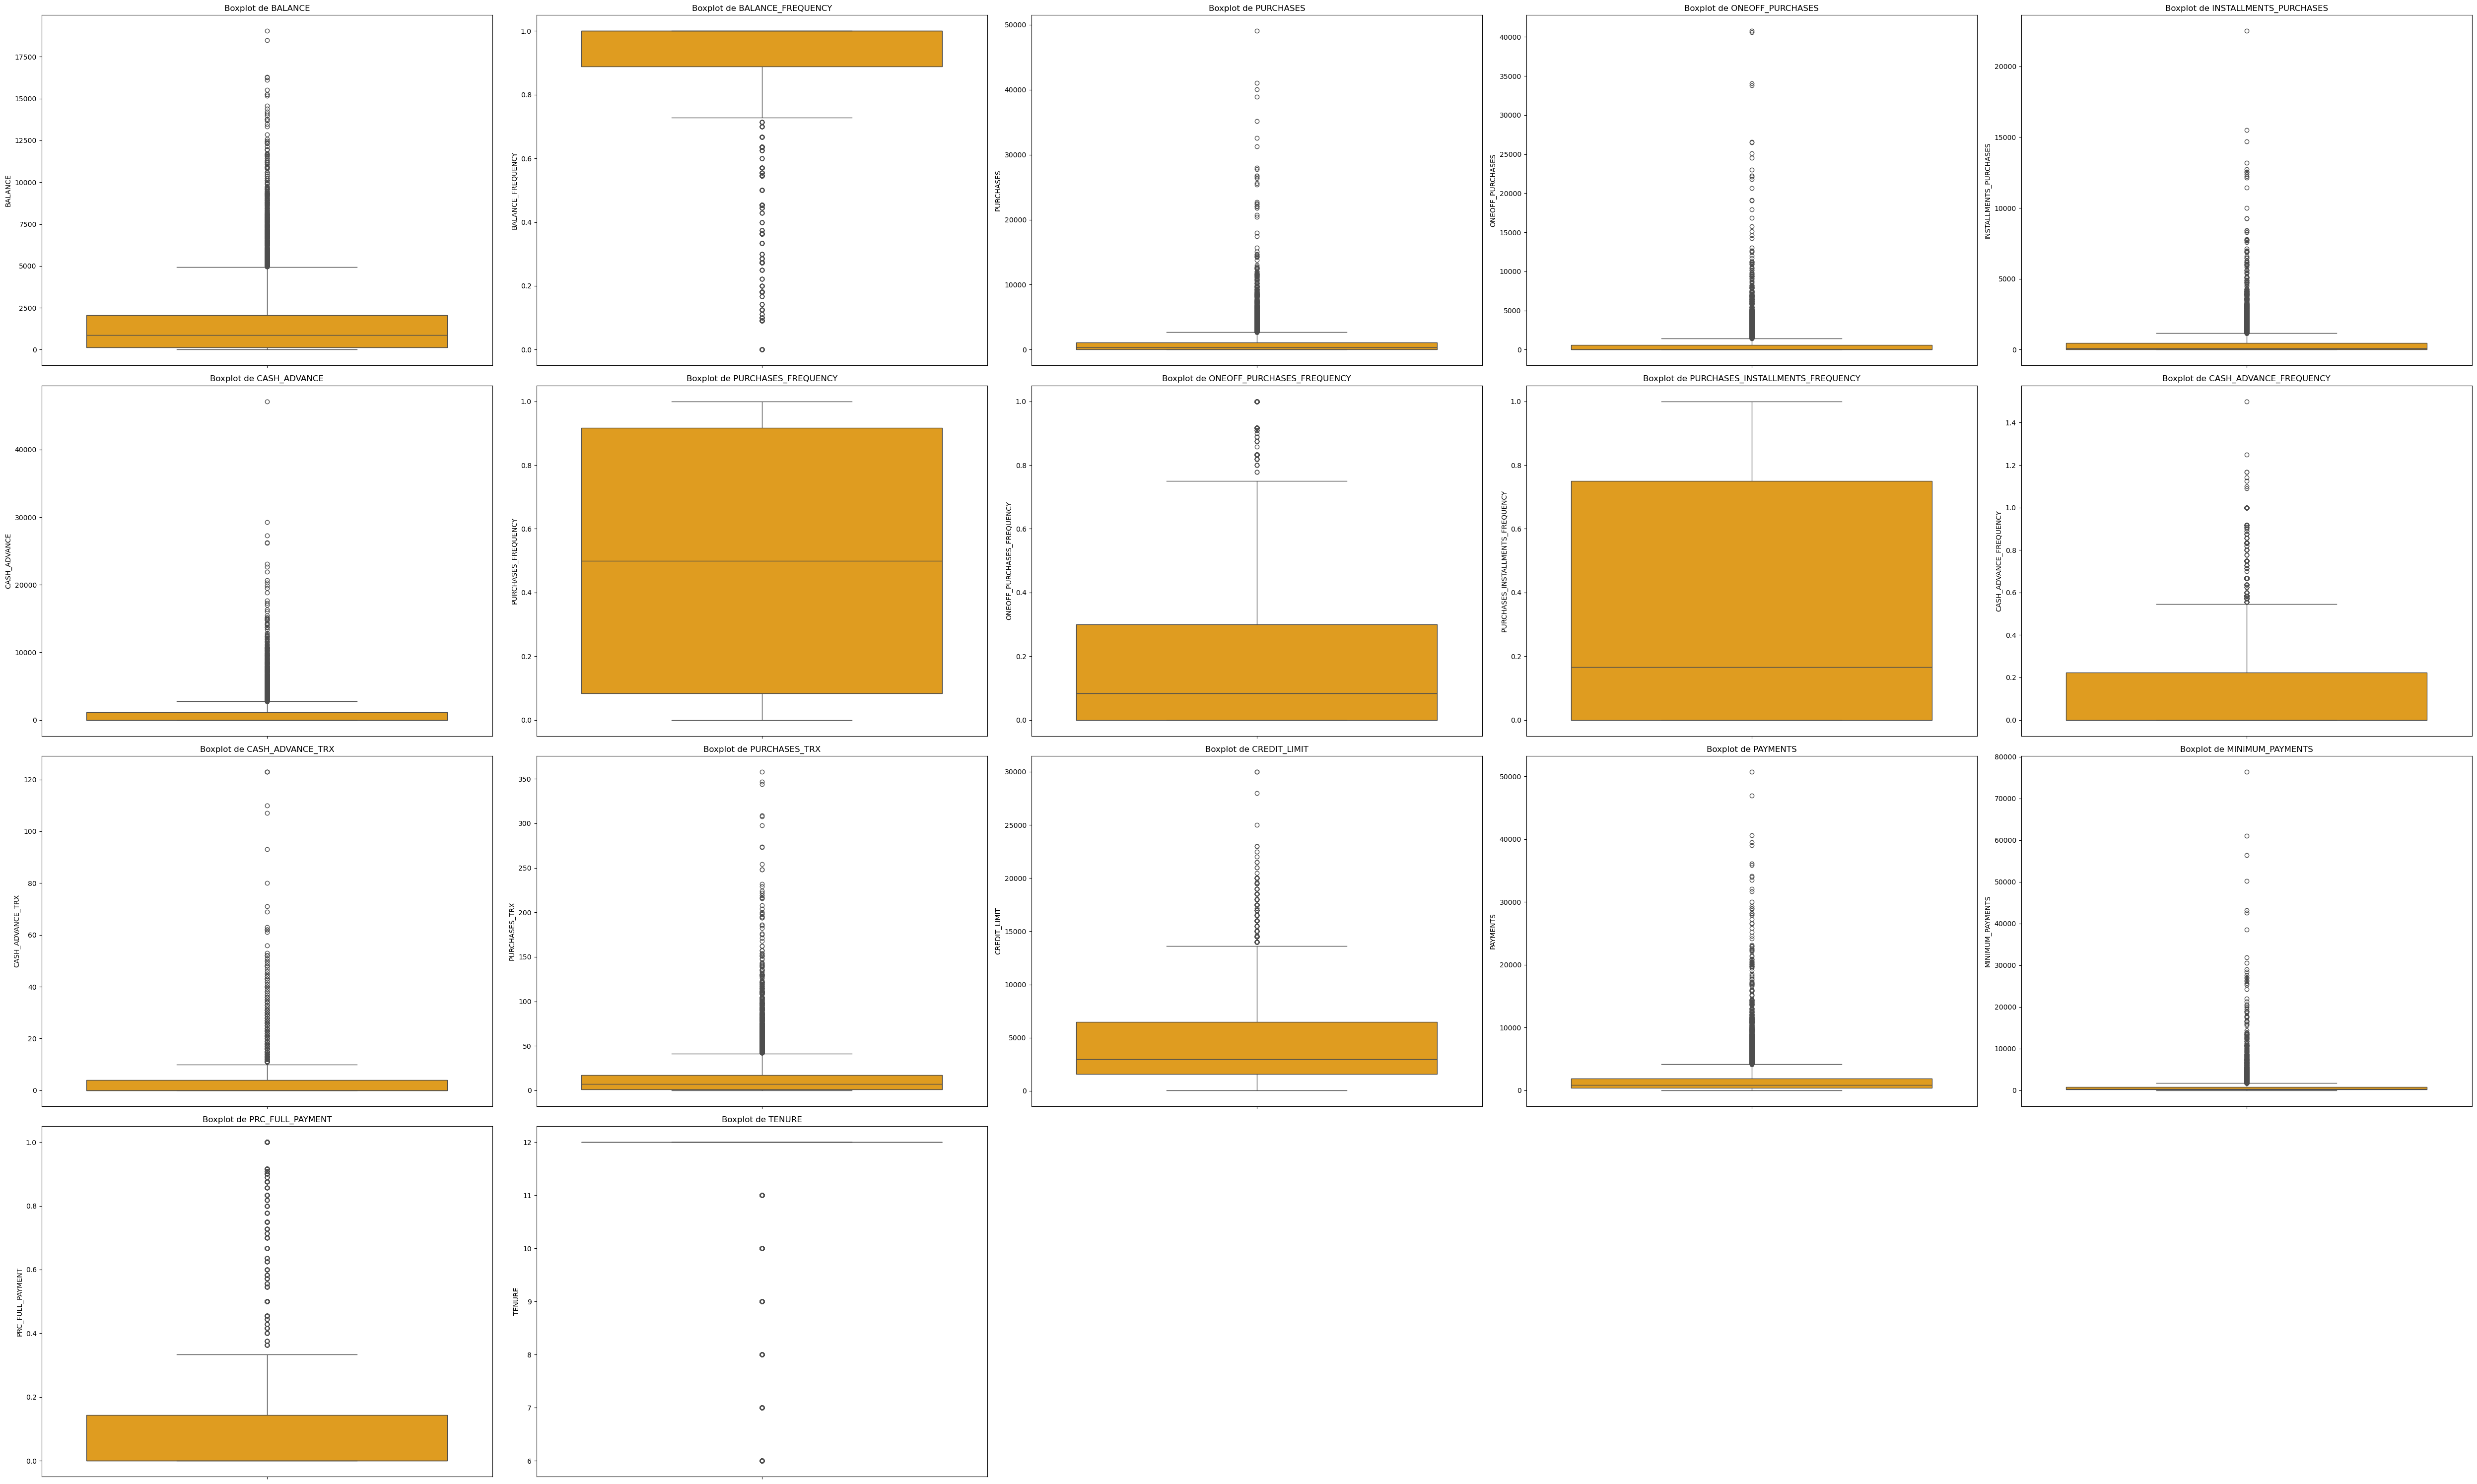

In [73]:
# extraer columnas numericas 
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# numero de columnas y filas
cols = 5
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(50, 30))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()

plt.show()

En los boxplots se logran visualizar muchos outliers. 

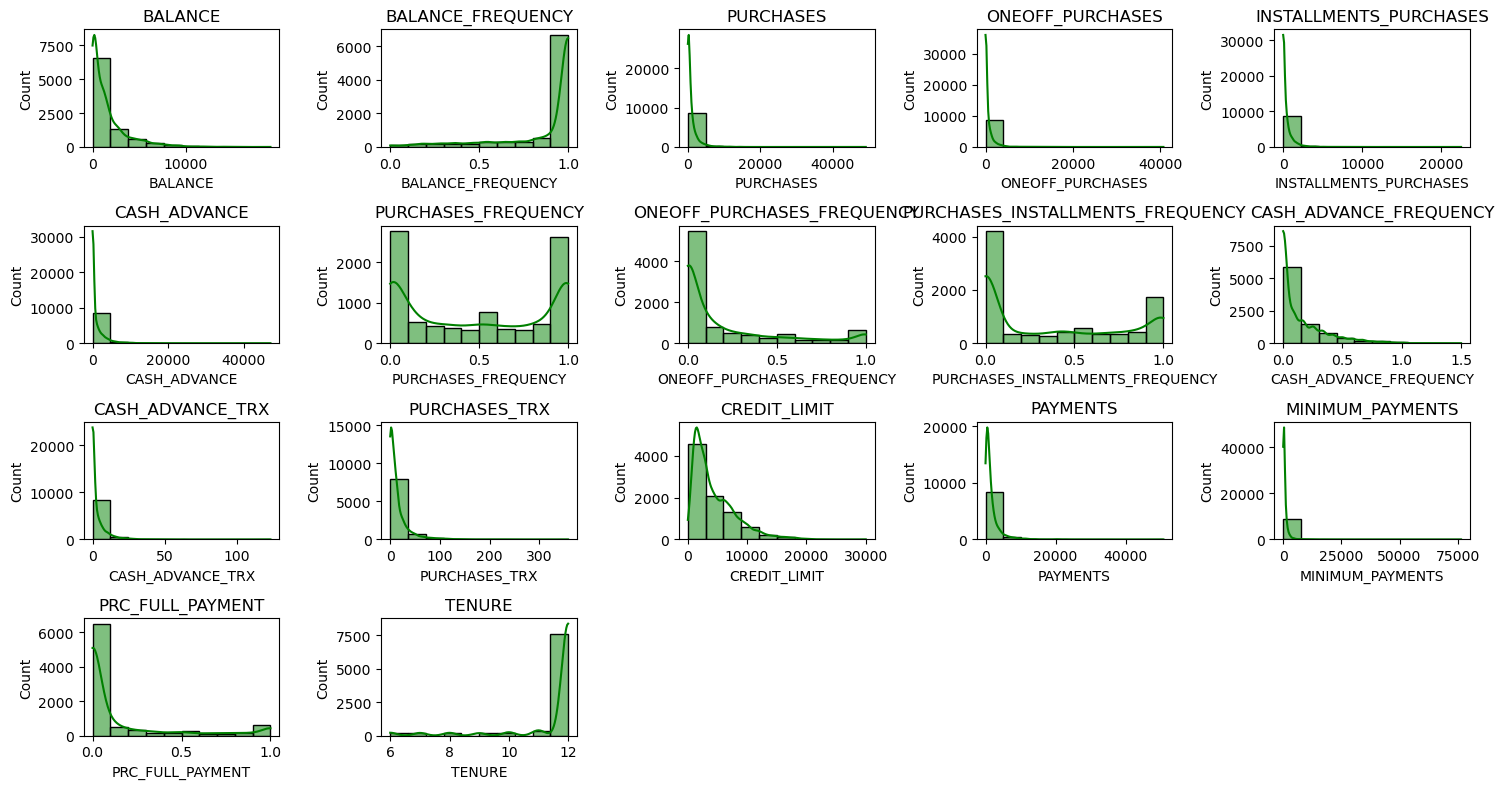

In [74]:
# distribucion de los datos
plt.figure(figsize=(15, 8))

# numero de columnas y filas
cols = 5
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i)  
    sns.histplot(df[col], kde=True, color="green", bins=10)  
    plt.title(f"{col}")
    plt.tight_layout()

plt.show()

In [75]:
# describe
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000,8949.000000
mean,1564.647593,0.877350,1003.316936,592.503572,411.113579,978.959616,0.490405,0.202480,0.364478,0.135141,3.249078,14.711476,4494.449450,1733.336511,844.999569,0.153732,11.517935
std,2081.584016,0.236798,2136.727848,1659.968851,904.378205,2097.264344,0.401360,0.298345,0.397451,0.200132,6.824987,24.858552,3638.815725,2895.168146,2332.906149,0.292511,1.337134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.365782,0.888889,39.800000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.282850,170.875613,0.000000,12.000000
50%,873.680279,1.000000,361.490000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,857.062706,312.343947,0.000000,12.000000
75%,2054.372848,1.000000,1110.170000,577.830000,468.650000,1113.868654,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.279320,788.721609,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


A continuacion se grafica un mapa de calor para identificar correlaciones.

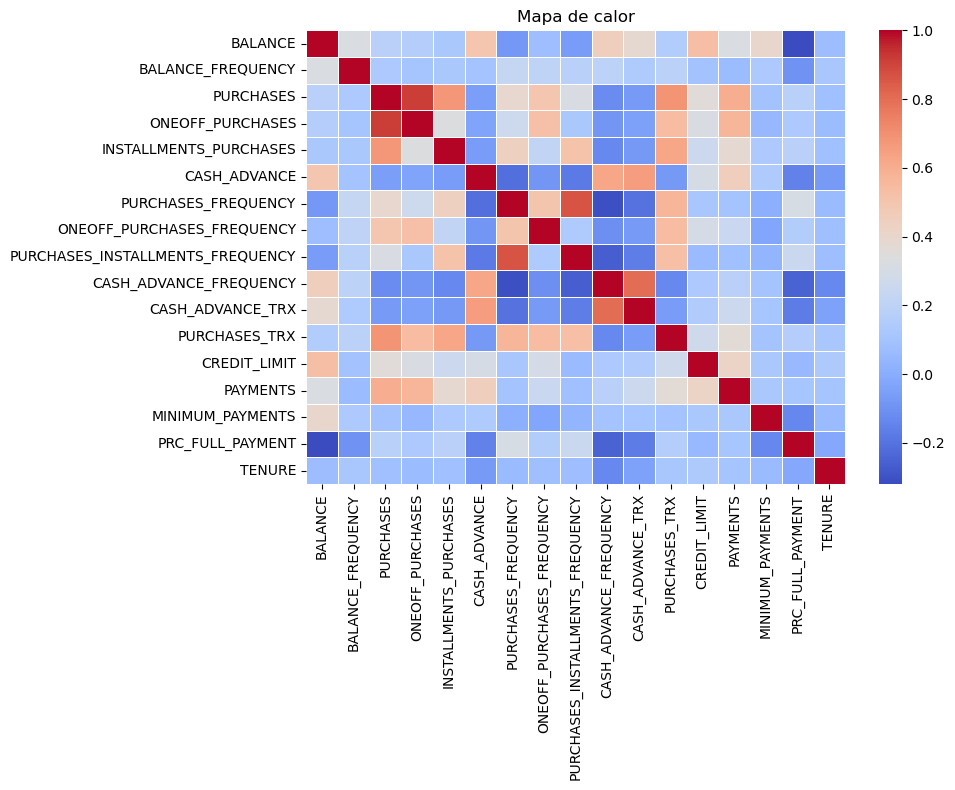

In [76]:
# variables numéricas
numerical_columns = df.select_dtypes(include=['int','float'])

# matriz de correlación
correlation_matrix = numerical_columns.corr(method="pearson")

# mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de calor')
plt.tight_layout()
plt.show()

### **4. Aplicacion de Kmeans**

Se aplicara el metodo de cluster utilzando kmeans.

In [95]:
# df
df.head(5).T

,0,1,2,3,4
CUST_ID,C10001,C10002,C10003,C10004,C10005
BALANCE,40.900749,3202.467416,2495.148862,1666.670542,817.714335
BALANCE_FREQUENCY,0.818182,0.909091,1.0,0.636364,1.0
PURCHASES,95.4,0.0,773.17,1499.0,16.0
ONEOFF_PURCHASES,0.0,0.0,773.17,1499.0,16.0
INSTALLMENTS_PURCHASES,95.4,0.0,0.0,0.0,0.0
CASH_ADVANCE,0.0,6442.945483,0.0,205.788017,0.0
PURCHASES_FREQUENCY,0.166667,0.0,1.0,0.083333,0.083333
ONEOFF_PURCHASES_FREQUENCY,0.0,0.0,1.0,0.083333,0.083333
PURCHASES_INSTALLMENTS_FREQUENCY,0.083333,0.0,0.0,0.0,0.0


Las variables utilizadas para el cluster seran todas a excepcion de customer id, ya que solo representa un identificador de cliente y   prc_full_payment ya que practicamente se engloba en otras variables. 

In [96]:
# columnas relevantes
columns_selected = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 
                    'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 
                    'PURCHASES_INSTALLMENTS_FREQUENCY', 'TENURE']

df_selected = df[columns_selected] 

In [97]:
# estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

Se busca identificar el numero de clusters optimo

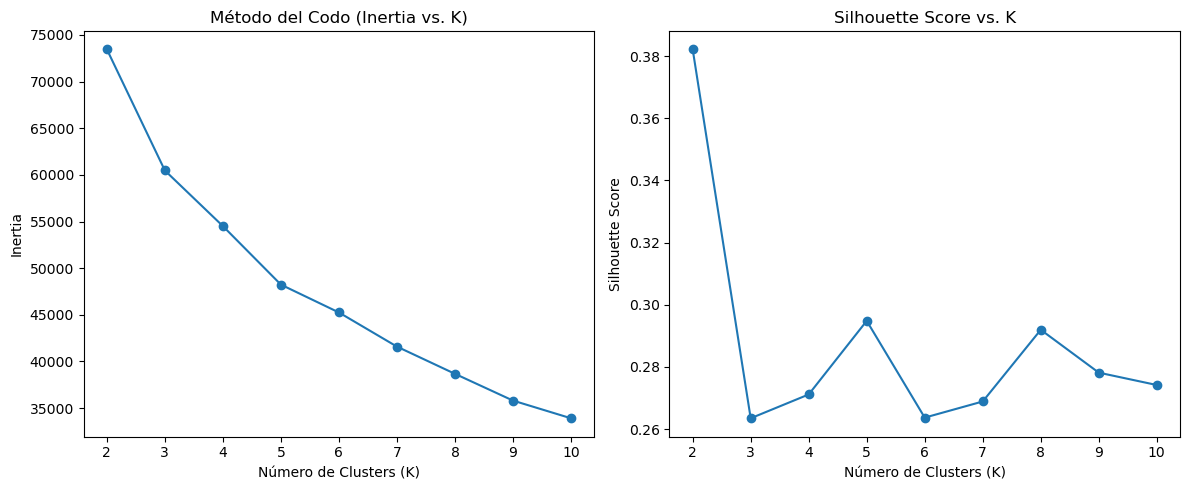

In [98]:
# Calcular Inertia y Silhouette Score para diferentes valores de K
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Crear gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Inertia
ax[0].plot(k_values, inertia, marker='o')
ax[0].set_title('Método del Codo (Inertia vs. K)')
ax[0].set_xlabel('Número de Clusters (K)')
ax[0].set_ylabel('Inertia')

# Gráfico de Silhouette Score
ax[1].plot(k_values, silhouette_scores, marker='o')
ax[1].set_title('Silhouette Score vs. K')
ax[1].set_xlabel('Número de Clusters (K)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [99]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_scaled)

KMeans(n_clusters=3, random_state=42)

In [100]:
# obtener las etiquetas de los clusters
kmeans_labels = kmeans.labels_

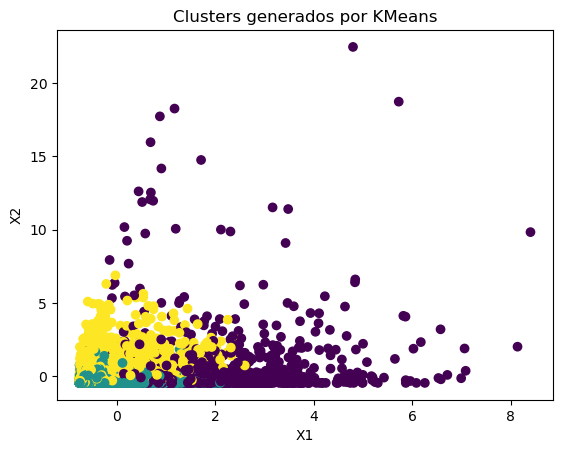

In [101]:
# Visualización de los clusters
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("Clusters generados por KMeans")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [102]:
# aplicar PCA para reducir la dimensionalidad 
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

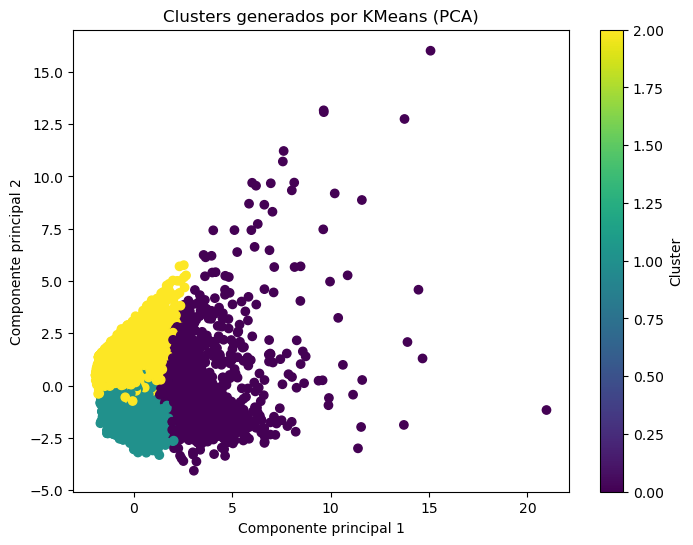

In [103]:
# grafico
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title("Clusters generados por KMeans (PCA)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')
plt.show()

Aplicando K-Means se busco realizar clustering de los datos, sin embargo, no se lograban visualizar bien los grupos, razon por la cual tambien se aplico PCA para reducir los datos a dos componentes principales. Asi, el grafico sugiere que hay 3 categorias principales definidas, sin embargo, hay poca distancia entre ellas lo que muestra cierta superposicion entre ellas. 

### **5. Aplicacion de DBSCAN**

In [104]:
# aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  
dbscan.fit(df_scaled)

DBSCAN()

In [105]:
# obtener las etiquetas de los clusters
labels = dbscan.labels_

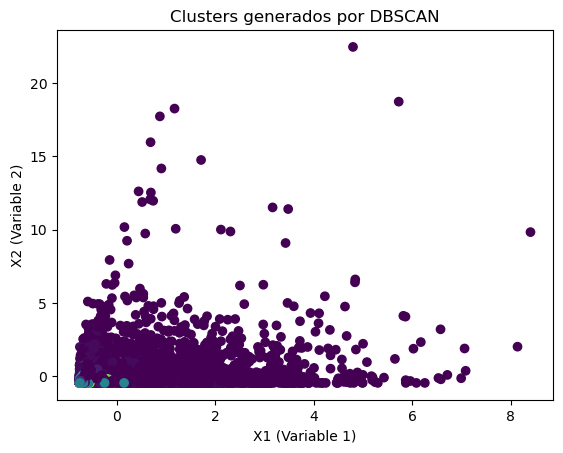

In [106]:
# visualización de los clusters
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=labels, cmap='viridis')
plt.title("Clusters generados por DBSCAN")
plt.xlabel("X1 (Variable 1)")
plt.ylabel("X2 (Variable 2)")
plt.show()

Se busca mejorar los parametros de DBSCAN

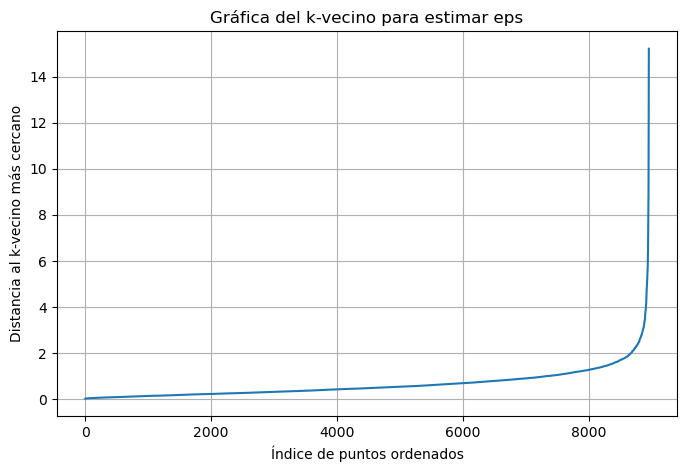

In [107]:
# configurar min_samples
min_samples = 5

# ajustar el modelo de k-vecino más cercano
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(df_scaled)
distances, indices = nbrs.kneighbors(df_scaled)

# ordenar las distancias
distances = np.sort(distances[:, -1])

# graficar las distancias para estimar eps
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('Gráfica del k-vecino para estimar eps')
plt.xlabel('Índice de puntos ordenados')
plt.ylabel('Distancia al k-vecino más cercano')
plt.grid()
plt.show()

Se aplican las mejoras para DBSCAN 

In [108]:
# aplicar DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)  
dbscan.fit(df_scaled)

DBSCAN(eps=2)

In [109]:
# obtener las etiquetas de los clusters
dbscan_labels = dbscan.labels_

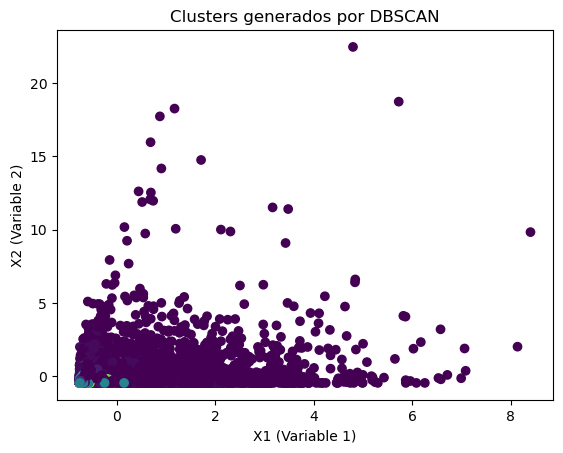

In [110]:
# visualización de los clusters
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=labels, cmap='viridis')
plt.title("Clusters generados por DBSCAN")
plt.xlabel("X1 (Variable 1)")
plt.ylabel("X2 (Variable 2)")
plt.show()

In [111]:
# aplicar PCA 
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

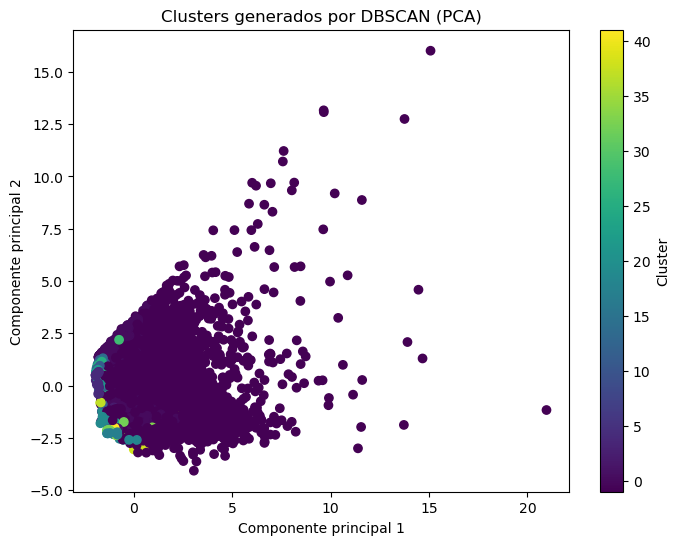

In [112]:
# grafico
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
plt.title("Clusters generados por DBSCAN (PCA)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')
plt.show()

Para este caso se aplico DBSCAN al conjunto de datos y posteriormente se aplico PCA para reducir a dos componentes principales. 

In [115]:
# calcular el Silhouette Score los modelos
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
dbscan_silhouette = silhouette_score(df_scaled, dbscan_labels)

# Calcular el Calinski-Harabasz Index para los modelos
kmeans_calinski = calinski_harabasz_score(df_scaled, kmeans_labels)
dbscan_calinski = calinski_harabasz_score(df_scaled, dbscan_labels)

# imprimir
print("KMeans Silhouette Score:", kmeans_silhouette)
print("DBSCAN Silhouette Score:", dbscan_silhouette)
print("KMeans Calinski-Harabasz Index:", kmeans_calinski)
print("DBSCAN Calinski-Harabasz Index:", dbscan_calinski)

KMeans Silhouette Score: 0.26350774569163105
DBSCAN Silhouette Score: 0.6325204943963507
KMeans Calinski-Harabasz Index: 2146.5737805651934
DBSCAN Calinski-Harabasz Index: 485.7956164536978


Para el caso de los Silhouette score, se tiene que mientras los valores se acerquen a 1, se tendra un buen agrupamiento, y cuando se acerquen a -1 se tiene un mal agrupamiento. En el caso de CH, evalua la dispersion de los clusters, un valor alto sugiere mejor separacion entre los clusters.

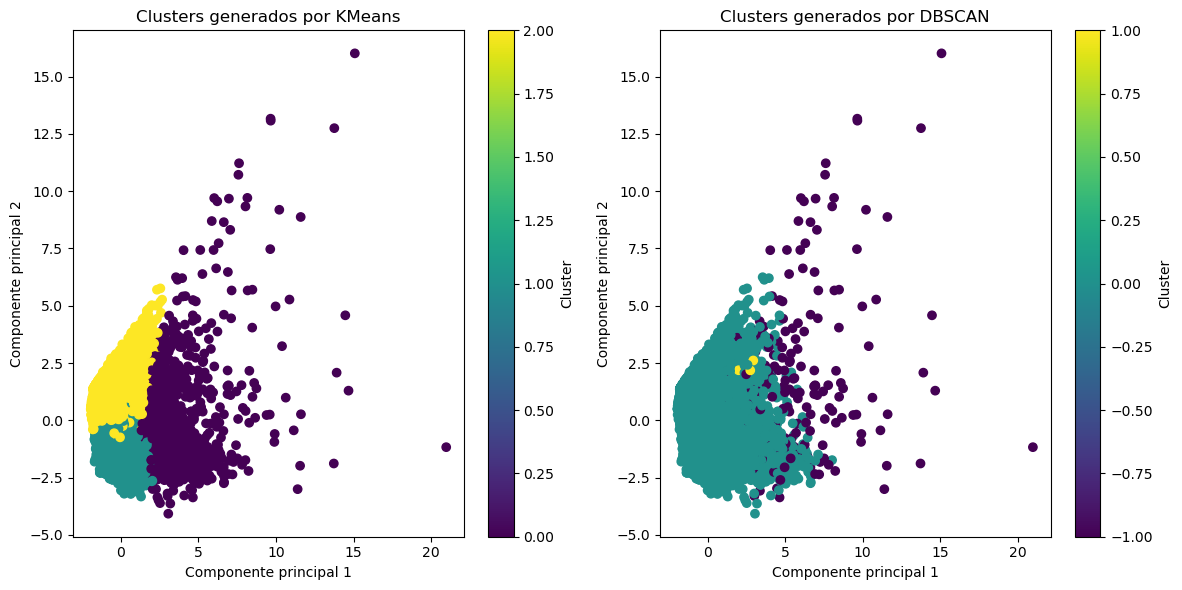

In [116]:
# Visualización de los clusters generados por KMeans
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("Clusters generados por KMeans")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')

# Visualización de los clusters generados por DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("Clusters generados por DBSCAN")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

El siluete score sugiere que para el caso de Kmeans, con un valor de 0.26, los clusters separados pero solapados. Sin embargo, para DBSCAN el valor de siluete es mayor, de 0.63, esto sugiere que los clusters generados por este metodo estan mejor definidos. En cuanto a CH, para Kmeans se tiene un valor de 2146, un valor alto, que sugiere que Kmeans logro una buena dispersion entre los clusters, pero no significa que los clusters hayan estado bien definidos. Para el caso de CH en DBSCAN, se tiene un valor de 485, el cual es bajo, probablemente sugiriendo que los clusters son mas pequeños y dispersos.

Asi, Kmeans muestra una mejor separacion entre los clusters, pero no se encuentran bien definidos, ya que los puntos de cada cluster pueden estar mas dispersos o mezclados con otros puntos. DBSCAN muestra clusters mas cohesivos, pero tiene menor separacion entre ellos. 

En conclusion, dependiendo del objetivo se puede optar por uno u otro algoritmo. Si se busca una separacion entre los clusters, Kmeans parece ser mejor opcion, pero en el caso de que se busque clusters cohesivos y que identifiquen puntos ruidosos DBSCAN es mejor.